In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.

from sortedcontainers import SortedSet
import json as js
import random
import heapq
import functools
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


In [3]:
# funkcje pomocnicze

def slope_coefficient(edge):
    return (edge[1][1]-edge[0][1])/(edge[1][0]-edge[0][0])

def get_value_of_edge_in_x(x, edge):
    if(x < edge[0][0] or x > edge[1][0]): return False
    a = slope_coefficient(edge)
    b = edge[0][1] - a*edge[0][0]
    return a*x + b

def point_x(point):
    return point[0]

def point_y(point):
    return point[1]

def get_first(element):
    return element[1]

def PlotToLines(plot):
    if len(plot) == 0:
        return None
    return plot[0].lines

def conversion_edges(edges):
    result = []
    for edge in edges:
        if edge[0][0] < edge[1][0]:
            result.append(((round(edge[0][0],10), round(edge[0][1],10)), (round(edge[1][0], 10), round(edge[1][1], 10))))
        else:
            result.append(((round(edge[1][0],10), round(edge[1][1],10)), (round(edge[0][0], 10), round(edge[0][1], 10))))
    return result
    
def point_of_intersection(edge1, edge2):
    x1 = edge1[0][0]
    x2 = edge1[1][0]
    x3 = edge2[0][0]
    x4 = edge2[1][0]
    y1 = edge1[0][1]
    y2 = edge1[1][1]
    y3 = edge2[0][1]
    y4 = edge2[1][1]
    a = (y2-y1)/(x2-x1) - (y4-y3)/(x4-x3)
    if(a == 0): return None #albo pokrywają się cześciwowo albo są równoległe, ale takich przypadków nie generuję
    b = y1-y3 + x3 *(y4-y3)/(x4-x3) - x1*(y2-y1)/(x2-x1)
    x = round(-b/a, 10)
    if(x1 <= x and x2 >= x and x3 <= x and x4 >= x):
        return (x, round(((y2-y1)/(x2-x1))*x + y1 - x1*((y2-y1)/(x2-x1)), 10))
    return None
    
    
def check_if_duplicates(listOfElems):
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True


def generating_edges(size = 10, lower_left_corner = (0,0), upper_right_corner = (20,20)):
    edges = []
    set_for_repeting_x = set() #ten set zbiera wspólrzędne x, jeśli wylosowana współrzędna x pojawi się w secie,
                               #to należy wybrać nową
    for i in range(size):
        x1 = round(np.random.uniform(lower_left_corner[0], upper_right_corner[0]), 10)
        y1 = round(np.random.uniform(lower_left_corner[1], upper_right_corner[1]), 10)
        x2 = round(np.random.uniform(lower_left_corner[0], upper_right_corner[0]), 10)
        y2 = round(np.random.uniform(lower_left_corner[1], upper_right_corner[1]), 10)
        if(x1 == x2): #krawędzie o takiej samej współrzędnej x końców, nie chcemy takich krawędzi
            i -= 1
            continue
        if (x1,x2) in set_for_repeting_x:
            i -= 1
            continue
        set_for_repeting_x.add((x1, x2))
        #set_for_repeting_x.add(x2)
        if(x2 > x1):
            edges.append(((x1,y1), (x2,y2)))
        else:
            edges.append(((x2,y2), (x1,y1)))
    #w tej cześci sprawdzamy, czy żadne trzy odcinki nie przecinaj się w jednym punkcie
    # wystarczy, że sprawdzymy wszystkie punkty przecięcia i jeśli, któreś się powtórzy to znaczy, że taka sytyacja
    #właśnie zaszła
    list_of_intersections = []
    for i in range(1, size):
        for j in range(0, i):
            intersection = point_of_intersection(edges[i], edges[j])
            if(intersection):
                list_of_intersections.append(intersection)
    if(check_if_duplicates(list_of_intersections)): return generating_edges(size, lower_left_corner, upper_right_corner)
    else:
        #edges.sort(key = lambda edge: slope_coefficient(edge))
        return edges


# edges = generating_edges()
# print(edges)
# print(point_of_intersection(((0,0), (2,2)), ((0,2),(2,0))))
# print(point_of_intersection(((2.417833357524468, 19.026622445411874), (19.97236071746643, 8.424708606170839)), ((3.941063476047242, 19.2052943891131), (19.439615964707897, 16.33543556664828))))

In [4]:
%matplotlib notebook
# plot1 = Plot([Scene([PointsCollection([])], 
#               [LinesCollection(generating_edges())])])
# plot1.draw()

plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


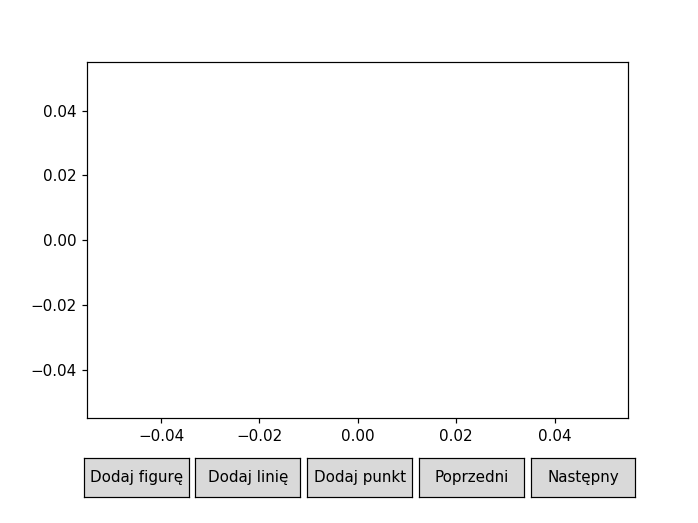

In [5]:
plot2 = Plot()
plot2.draw()

In [6]:
#zapis do plików JSON, należy wybrać, jak generować edges i odkomentować
#edges = conversion_edges(plot1.get_added_lines()[0].lines)
#edges = generating_edges(size = 7)

with open("sample.json", "w") as outfile: 
    js.dump(edges, outfile) 


with open('sample.json', 'r') as openfile: 
  
    # Reading from json file 
    json_object = js.load(openfile)

NameError: name 'edges' is not defined

10


<IPython.core.display.Javascript object>


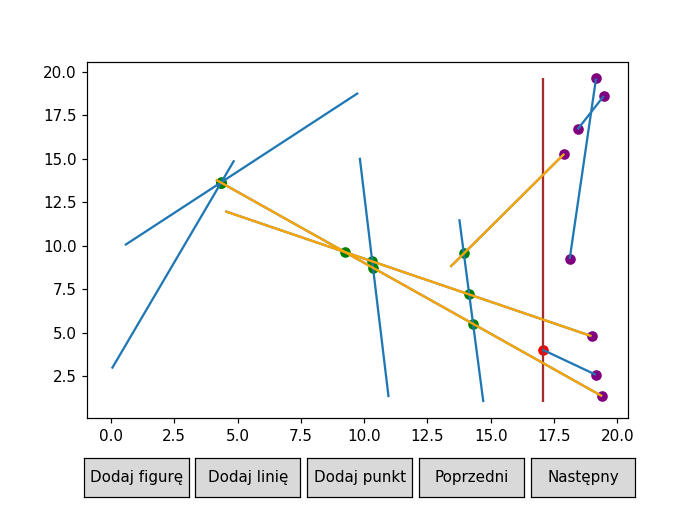

In [9]:
#Wersja dla wszystkich punktów
def find_intersections(edges):
    Q = SortedSet(key = lambda point:-point_x(point))
    T = SortedSet()
    edge_dict = {}
    rep_eliminate = {}
    intersected_edges = {}
    used_edges = set([])
    result = set([])
    scenes = []
    
    def insert_edge(edge):
        nonlocal T
        nonlocal Q
        nonlocal intersected_edges
        nonlocal used_edges
        nonlocal rep_eliminate
        T.add(edge) # wstaw edge do T
        
        for idx in range(len(T)):
            edge1 = T[idx]  

            #jesli edge przecina się z sąsiadem to wstaw punkt przecięcia do Q o ile go tam nie ma       
            if idx - 1 >= 0:
                intersection = point_of_intersection(T[idx-1], edge)
                if intersection is not None \
                and (rep_eliminate[T[idx-1]], rep_eliminate[edge]) not in used_edges and (rep_eliminate[edge], rep_eliminate[T[idx-1]]) not in used_edges:
                    Q.add(intersection)
                    intersected_edges[intersection] = (T[idx-1], edge)
                    used_edges.add((rep_eliminate[T[idx-1]], rep_eliminate[edge]))

            #jesli edge przecina się z sąsiadem to wstaw punkt przecięcia do Q o ile go tam nie ma
            if idx + 1 < len(T):
                intersection = point_of_intersection(edge, T[idx+1])
                if intersection is not None and \
                (rep_eliminate[edge], rep_eliminate[T[idx+1]]) not in used_edges and (rep_eliminate[T[idx+1]], rep_eliminate[edge]) not in used_edges:
                    Q.add(intersection)
                    intersected_edges[intersection] = (edge, T[idx+1]) 
                    used_edges.add((rep_eliminate[edge], rep_eliminate[T[idx+1]]))
                
                
    def remove_edge(edge):
        nonlocal T
        nonlocal Q
        nonlocal used_edges
        nonlocal rep_eliminate
        idx = T.index(edge)
        #teraz sprawdzamy czy edge (T[i]) miał dwóch sąsiadów w T
        #jesli się przecinają to wstawiamy punkt przecięcia do Q jeśli go nie ma
        if idx - 1 >= 0 and idx + 1 < len(T):
            intersection = point_of_intersection(T[idx-1], T[idx+1])
            if intersection is not None and \
            (rep_eliminate[T[idx-1]], rep_eliminate[T[idx+1]]) not in used_edges and (rep_eliminate[T[idx+1]], rep_eliminate[T[idx-1]]) not in used_edges:
                Q.add(intersection)
                intersected_edges[intersection] = (T[idx-1], T[idx+1])
                used_edges.add((rep_eliminate[T[idx-1]], rep_eliminate[T[idx+1]]))
        T.remove(edge)
        
    def edges_intersected(intersection):
        nonlocal T
        nonlocal intersected_edges
        result.add(intersection)
        edge1, edge2 = intersected_edges[intersection]
        remove_edge(edge1)
        remove_edge(edge2)
        x = point_x(intersection) + 0.001 # tutaj dodajemy odrobinkę, żeby już złapało połoenie prostych po przecięciu
        edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
        edges_changed_order.update(T)
        T = edges_changed_order
        insert_edge(edge1)
        insert_edge(edge2)
        
    counter = 0
    for edge in edges:
        #przypisujemy każdemy punktowi (edge[0], edge[1]) jego krawędź
        edge_dict[edge[0]] = edge
        edge_dict[edge[1]] = edge
        rep_eliminate[edge] = counter
        counter+=1
        
        Q.add(edge[0])
        Q.add(edge[1])
    min_y = point_y(functools.reduce(lambda curr_min_y, point: point if point[1] < curr_min_y[1] else curr_min_y, edge_dict.keys()))
    max_y = point_y(functools.reduce(lambda curr_max_y, point: point if point[1] > curr_max_y[1] else curr_max_y, edge_dict.keys()))
    x = point_x(Q[0])
    edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
    edges_changed_order.update(T)
    T = edges_changed_order
    while len(Q) > 0:
        event = Q.pop()
        #if(event[0] <= list(result)[-1][0]): continue
        scenes.append(Scene([PointsCollection([event], color='red'), PointsCollection(list(Q), color='purple'), PointsCollection(list(result), color = "green")],
        [LinesCollection([ ((point_x(event), min_y), (point_x(event), max_y)) ], color='brown') ,LinesCollection(edges), LinesCollection(list(T), color = "orange")]
                ))
        if event in edge_dict:
            edge = edge_dict[event]
            if event == edge[0]:
                ###update_keys
                x = point_x(event)
                edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
                edges_changed_order.update(T)
                T = edges_changed_order #tutaj uaktualniam dowiązania
                ###insert_line
                insert_edge(edge)
            else:
                x = point_x(event)
                edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
                edges_changed_order.update(T)
                T = edges_changed_order #tutaj uaktualniam dowiązania
                ###remove_line
                remove_edge(edge)
        else:
            edges_intersected(event)
    scenes.append(Scene([PointsCollection(list(result), color = "green")],
        [LinesCollection(edges)]
                ))
    return scenes, list(zip(list(intersected_edges.keys()), list(intersected_edges.values()))), len(result)
            
%matplotlib notebook
edges = generating_edges(size = 10)
#edges = conversion_edges(plot1.get_added_lines()[0].lines)
#edges = conversion_edges(plot2.get_added_lines()[0].lines)
#edges = conversion_edges(json_object)
#plik JSON należy obłożyć dodatkową funkcją conversion_edges np. conversion_edges(json_object)
scenes, result, len_of_result = find_intersections(edges)
print(len_of_result)
plot = Plot(scenes)
plot.draw()


[((4.3382790472, 11.6666385863), (((0.9458353464, 9.5566289624), (14.2719819998, 17.845137238)), ((2.1146396282, 18.7073238828), (7.2973918539, 2.2972319051))))]


<IPython.core.display.Javascript object>


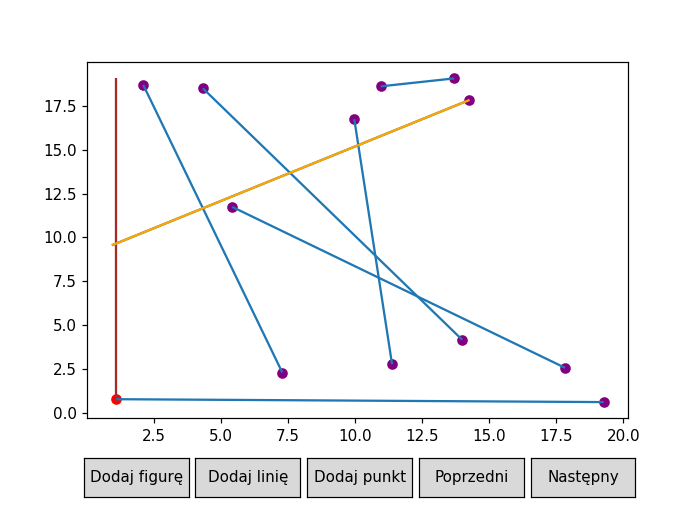

In [8]:
#Wersja dla jednego przecięcia
def find_intersections(edges):
    scenes = []
    Q = SortedSet(key = lambda point:-point_x(point))
    T = SortedSet()
    edge_dict = {}
    intersected_edges = {}
    
    def insert_edge(edge):
        nonlocal T
        nonlocal Q
        nonlocal intersected_edges
        T.add(edge)
        idx = T.index(edge)
        
        if idx + 1 < len(T):
            intersection = point_of_intersection(edge, T[idx+1])
            if intersection is not None and intersection not in Q:
                Q.add(intersection)
                intersected_edges[intersection] = (edge, T[idx+1])
        if idx - 1 >= 0:
            intersection = point_of_intersection(T[idx-1], edge)
            if intersection is not None and intersection not in Q:
                Q.add(intersection)
                intersected_edges[intersection] = (T[idx-1], edge)
                
    def remove_edge(edge):
        nonlocal T
        nonlocal Q
        idx = T.index(edge)
        if idx - 1 >= 0 and idx + 1 < len(T):
            intersection = point_of_intersection(T[idx-1], T[idx+1])
            if intersection is not None:
                Q.add(intersection)
                intersected_edges[intersection] = (T[idx-1], T[idx+1])
        T.remove(edge)
        
    for edge in edges:
        #przypisujemy każdemy punktowi (edge[0], edge[1]) jego krawędź
        edge_dict[edge[0]] = edge
        edge_dict[edge[1]] = edge
        Q.add(edge[0])
        Q.add(edge[1])
    min_y = point_y(functools.reduce(lambda curr_min_y, point: point if point[1] < curr_min_y[1] else curr_min_y, edge_dict.keys()))
    max_y = point_y(functools.reduce(lambda curr_max_y, point: point if point[1] > curr_max_y[1] else curr_max_y, edge_dict.keys()))
    x = point_x(Q[0])
    edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
    edges_changed_order.update(T)
    T = edges_changed_order
    while len(Q) > 0:
        event = Q.pop()
        
        scenes.append(Scene([PointsCollection([event], color='red'), PointsCollection(list(Q), color='purple'), PointsCollection(list(intersected_edges.keys()), color = "green")],
        [LinesCollection([ ((point_x(event), min_y), (point_x(event), max_y)) ], color='brown') , LinesCollection(edges), LinesCollection(list(T), color = "orange")]
                ))
        if(len(intersected_edges) > 0): break
        if event in edge_dict:
            edge = edge_dict[event]
            if event == edge[0]:
                ###update_keys
                x = point_x(event)
                edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
                edges_changed_order.update(T)
                T = edges_changed_order
                ###insert_line
                insert_edge(edge)
            else:
                x = point_x(event)
                edges_changed_order = SortedSet(key = lambda edge: get_value_of_edge_in_x(x, edge))
                edges_changed_order.update(T)
                T = edges_changed_order
                ###remove_line
                remove_edge(edge)
    scenes.append(Scene([PointsCollection(list(intersected_edges.keys()), color = "green")],
        [LinesCollection(edges)]
                ))
    return scenes, list(zip(list(intersected_edges.keys()), list(intersected_edges.values())))
            
%matplotlib notebook
edges = generating_edges(size = 7)
#edges = conversion_edges(plot1.get_added_lines()[0].lines)
scenes, result = find_intersections(edges)
print(result)
plot = Plot(scenes)
plot.draw()
